In [27]:
import pandas as pd
import cv2
import numpy as np


In [28]:
train_data = pd.read_csv("dataset/training.csv")

In [29]:
train_data.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [49]:
import cv2
import numpy as np

def rotate_image_and_points(image_array, points, angle):
    """
    Rotates a 96x96 grayscale image and adjusts the facial feature locations accordingly.
    
    Parameters:
    - image_array: 96x96 numpy array representing the image.
    - points: A pandas Series with columns for (x, y) pairs of facial features.
    - angle: The rotation angle in degrees.

    Returns:
    - rotated_image: The rotated image.
    - rotated_points: A numpy array with the rotated facial feature coordinates.
    """
    h, w = image_array.shape[:2]

    # Ensure the image is of type uint8 for OpenCV to process it
    image_array = image_array.astype(np.uint8)
    
    # Compute the center of the image (rotation will be around the center)
    center = (w // 2, h // 2)
    
    # Compute the rotation matrix for the given angle
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Rotate the image using warpAffine
    rotated_image = cv2.warpAffine(image_array, rotation_matrix, (w, h))

    # Initialize a list to store rotated points
    rotated_points = []
    
    # Iterate over the (x, y) pairs in the facial feature points
    for i in range(0, len(points), 2):
        x = points[i]
        y = points[i + 1]
        
        # Apply the rotation matrix to each point
        point = np.array([[x], [y], [1]])  # Convert point to homogeneous coordinates
        rotated_point = np.dot(rotation_matrix, point).flatten()
        
        # Append the rotated x and y to the list
        rotated_points.extend([rotated_point[0], rotated_point[1]])

    return rotated_image, np.array(rotated_points)

def process_rotation_to_original_format(train_data, angle):
    rotated_data = []

    for i in range(len(train_data)):
        # Convert the image data from space-separated string to a 96x96 NumPy array
        image = np.fromstring(train_data.iloc[i]['Image'], dtype=int, sep=' ').reshape(96, 96)

        # Ensure the image is converted to uint8 for OpenCV
        image = image.astype(np.uint8)
        
        # Extract the facial feature points (x, y coordinates) as a numpy array
        points = train_data.iloc[i][:-1].to_numpy()

        # Rotate both the image and the points
        rotated_image, rotated_points = rotate_image_and_points(image, points, angle)
        
        # Convert the rotated image back to space-separated string format
        rotated_image_flat = ' '.join(map(str, rotated_image.flatten()))

        # Append the rotated points and image as a new row in the dataset
        rotated_row = list(rotated_points) + [rotated_image_flat]
        rotated_data.append(rotated_row)
    
    # Create a DataFrame for the rotated data
    rotated_df = pd.DataFrame(rotated_data, columns=train_data.columns)
    
    return rotated_df

# Apply a 15-degree rotation and format the output
rotated_df = process_rotation_to_original_format(train_data, 15)



KeyboardInterrupt: 

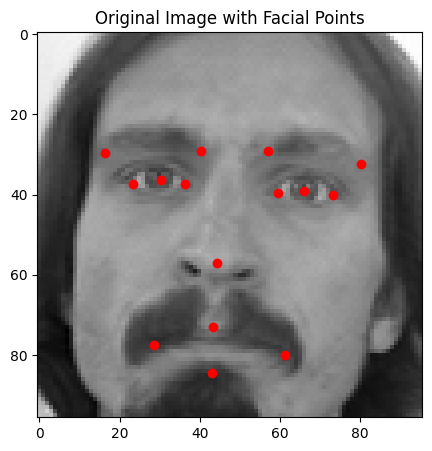

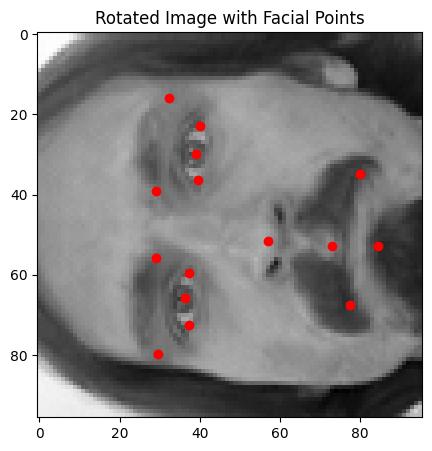

In [58]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rotate_image_and_points(image_array, points, angle):
    """
    Rotates a 96x96 grayscale image and adjusts the facial feature locations accordingly.
    
    Parameters:
    - image_array: 96x96 numpy array representing the image.
    - points: A pandas Series with columns for (x, y) pairs of facial features.
    - angle: The rotation angle in degrees.

    Returns:
    - rotated_image: The rotated image (in uint8 format).
    - rotated_points: A numpy array with the rotated facial feature coordinates.
    """
    h, w = image_array.shape[:2]

    # Ensure the image is of type uint8 and pixel values are scaled correctly
    image_array = image_array.astype(np.uint8)
    
    # Compute the center of the image (rotation will be around the center)
    center = (w // 2, h // 2)
    
    # Compute the rotation matrix for the given angle
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Rotate the image using warpAffine
    rotated_image = cv2.warpAffine(image_array, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    # Initialize a list to store rotated points
    rotated_points = []
    
    # Iterate over the (x, y) pairs in the facial feature points
    for i in range(0, len(points), 2):
        x = points[i]
        y = points[i + 1]
        
        # Apply the rotation matrix to each point
        point = np.array([[x], [y], [1]])  # Convert point to homogeneous coordinates
        rotated_point = np.dot(rotation_matrix, point).flatten()
        
        # Append the rotated x and y to the list
        rotated_points.extend([rotated_point[0], rotated_point[1]])

    return rotated_image, np.array(rotated_points)

def visualize_image_and_points(image_array, points, title):
    """
    Visualizes the image and plots the facial feature points.
    
    Parameters:
    - image_array: 96x96 grayscale image (numpy array)
    - points: List or array of facial feature points (x, y) pairs
    - title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(image_array, cmap='gray')
    for i in range(0, len(points), 2):
        plt.scatter(points[i], points[i+1], color='red')
    plt.title(title)
    plt.show()

# Example usage: Visualizing the rotated image and points
i = 0  # Replace with desired index from your dataset
image_data = np.fromstring(train_data.iloc[i]['Image'], dtype=int, sep=' ').reshape(96, 96)
points = train_data.iloc[i][:-1].to_numpy()

# Rotate the image and the points
rotated_image, rotated_points = rotate_image_and_points(image_data, points, 90)

# Visualize the original and rotated images
visualize_image_and_points(image_data, points, title="Original Image with Facial Points")
visualize_image_and_points(rotated_image, rotated_points, title="Rotated Image with Facial Points")


In [ ]:
def create_rotated_dataframe(original_df, angle):
    """
    Creates a new DataFrame with rotated images and corresponding facial feature locations.
    
    Parameters:
    - original_df: The original DataFrame with facial feature locations and images.
    - angle: The rotation angle in degrees.

    Returns:
    - rotated_df: A DataFrame containing the rotated images and facial feature points.
    """
    rotated_data = []
    
    for i in range(len(original_df)):
        # Extract the image and the points for each entry
        image_data = np.fromstring(original_df.iloc[i]['Image'], dtype=int, sep=' ').reshape(96, 96)
        points = original_df.iloc[i][:-1].to_numpy()  # Extract facial feature points (x, y) pairs

        # Rotate the image and points
        rotated_image, rotated_points = rotate_image_and_points(image_data, points, angle)
        
        # Convert the rotated image back to space-separated string format
        rotated_image_str = ' '.join(map(str, rotated_image.flatten()))
        
        # Combine the rotated points and image into one row, preserving the original structure
        rotated_row = np.concatenate([rotated_points, [rotated_image_str]])
        
        rotated_data.append(rotated_row)
    
    # Create a new DataFrame with the same columns as the original
    rotated_df = pd.DataFrame(rotated_data, columns=original_df.columns)
    
    return rotated_df

# Example: Rotate all images in the DataFrame by 90 degrees and create a new DataFrame
rotated_df = create_rotated_dataframe(train_data, angle=90)



In [57]:
rotated_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,63.090302187361104,34.64143398275827,27.835917358637104,41.41618888654607,57.02561942801361,36.934368090683485,70.19573238371889,33.73940059007912,34.007086665579976,40.76448994470562,...,57.68428347168207,69.02017672860657,75.46561135717721,36.881472233681066,81.40492441804557,49.92609233051829,73.29899149991547,52.73983720975147,84.50281764490157,64 62 64 66 68 70 72 73 85 94 101 108 115 121 ...
1,60.404012532667124,31.186785525926666,26.798190364333117,38.61640890494341,55.192614326493015,32.898181373185295,66.89107895297614,30.708604942956335,32.91253503107444,37.92309290846931,...,55.34650228203287,63.47253053379647,73.20629820559003,42.82044560649929,78.42493129062224,52.4924250925437,69.84829046338966,55.25477546612318,84.85841623161053,199 219 225 224 225 224 216 209 206 211 211 20...
2,61.087813726877854,30.94099515976812,28.098294790615306,39.7805101174309,56.00038972863776,33.76527882918492,67.17849009603542,30.770115862826685,35.007059496514586,39.390424711322204,...,53.46480104029746,66.8601973588143,68.84315065473932,40.6137924082591,75.58357885323777,53.04331069841791,69.6232800139765,55.234881395914186,77.80233320541176,97 99 109 112 114 114 107 98 96 97 97 99 100 9...
3,61.85952888103924,33.169320741120444,29.788238044377557,41.762797221027604,57.29788024292394,36.322820398244886,68.99662034039606,32.41561674749493,35.57936844068054,41.75605346342424,...,52.95088715924079,71.39301309621742,67.30703571630686,44.391835171011884,76.08635953004566,55.94243608848248,68.7428279552959,59.27387213745628,76.31531059952277,6 14 17 27 32 46 81 115 136 147 153 160 160 16...
4,63.91867433097195,35.060295521905104,30.204343108840895,42.459084715417475,56.037288477326626,37.17210649662744,69.58011175255047,33.81580770861323,35.052974630774386,42.24985690189349,...,65.53059517220947,67.88081977645156,73.23765677439097,39.26953533003149,80.35953557921376,51.719801529476854,73.6175270914277,54.41629612775267,86.52315053038475,43 43 41 41 54 63 70 72 83 93 102 108 112 115 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,62.559565214621514,27.371354158105788,27.94434071680547,43.67640565149122,nan,nan,nan,nan,nan,nan,...,66.31185667964375,nan,nan,nan,nan,nan,nan,58.544353193128984,77.9762579217604,170 162 184 193 192 193 194 195 195 195 198 20...
7045,63.022893377686344,34.00026014518957,28.992209942132817,44.7593536192738,nan,nan,nan,nan,nan,nan,...,66.01454915025256,nan,nan,nan,nan,nan,nan,57.96963331109828,76.36935449751458,106 107 117 123 130 125 125 131 133 137 133 13...
7046,63.16679133914815,32.38779399221229,30.070903268804848,44.19580898111148,nan,nan,nan,nan,nan,nan,...,66.47165657784326,nan,nan,nan,nan,nan,nan,57.20762002451879,76.71236260876967,215 211 197 202 195 189 191 198 200 209 218 21...
7047,68.0741397301181,34.187444800952065,29.26745149122715,45.536745788997344,nan,nan,nan,nan,nan,nan,...,65.37410971043855,nan,nan,nan,nan,nan,nan,58.16999044583768,77.97565553676533,185 194 201 204 202 203 201 197 195 195 194 19...
